<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [2]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [1]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = r'C:\Users\Дмитрий Мошкин\Documents\GitHub\moshkin\MFTI_Yandex_DA_specialisation\6 course\capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                              session_length=10, window_size=10):
    f = open(site_freq_path, 'rb')
    site_freq = pickle.load(f)
    
    sessions = []
    user_id = 1
    user_ids = []
    time_diff = []
    session_timespan = []
    num_of_unique_sites = []
    start_hour = []
    day_of_week = []
    i = 0 
    
    for file in glob(path_to_csv_files + '/*.csv'):
        df = pd.read_csv(file, parse_dates=[0])
        timestamps = df.iloc[:, 0]
        sites = df.iloc[:, 1].tolist()

        sites_len = len(sites)
        i_normalized = 0 
        
        while i_normalized < sites_len:
            sessions.append([0] * session_length)
            user_ids.append(user_id)
            
            time_diff.append([0] * session_length)
            if i_normalized + session_length < sites_len:
                sess_timestamps = timestamps.iloc[i_normalized:(i_normalized + session_length)]
            else:
                sess_timestamps = timestamps.iloc[i_normalized:sites_len]
            sess_timespan = int((sess_timestamps.max() - sess_timestamps.min()) / np.timedelta64(1, 's'))
            session_timespan.append(sess_timespan)
            
            start_hour.append(sess_timestamps.min().hour)
            day_of_week.append(sess_timestamps.min().dayofweek)
            
            for j in range(session_length):
                cur_ind = i_normalized + j
                if cur_ind >= sites_len: break
                sessions[i][j] = site_freq[sites[cur_ind]][0]
                
                if j > 9 or cur_ind > (sites_len - 2):
                    continue
                time_diff[i][j] = int((timestamps[cur_ind + 1] - timestamps[cur_ind]) / np.timedelta64(1, 's'))
            
            unique_sites = set(sessions[i])
            try: unique_sites.remove(0)
            except: pass
            num_of_unique_sites.append(len(unique_sites))
                
            i += 1
            i_normalized += window_size
            
        user_id += 1
    
    X1 = np.array(sessions)
    X2 = np.array(time_diff)
    X3 = np.array(session_timespan).reshape(X1.shape[0], -1)
    X4 = np.array(num_of_unique_sites).reshape(X1.shape[0], -1)
    X5 = np.array(start_hour).reshape(X1.shape[0], -1)
    X6 = np.array(day_of_week).reshape(X1.shape[0], -1)
    y = np.array(user_ids).reshape(X1.shape[0], -1)
    
    sessions_arr = np.hstack( (X1, X2, X3, X4, X5, X6, y) )
    
    return pd.DataFrame(sessions_arr, columns=feature_names)

**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [5]:
train_data_toy

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0      3      2      2      9      2      1      7      5      8      10   
1      3      1      1      1      0      0      0      0      0       0   
2      3      2      6      6      2      0      0      0      0       0   
3      4      1      2      1      2      1      1      5     11       4   
4      4      1      2      0      0      0      0      0      0       0   

   time_diff1  time_diff2  time_diff3  time_diff4  time_diff5  time_diff6  \
0         287        1184        6278         186           2           1   
1           2           3          55           0           0           0   
2         287        1184        6278         186           0           0   
3         287        1184        6278         186           2           1   
4         287        1184           0           0           0           0   

   time_diff7  time_diff8  time_diff9  time_diff10  session_timespan  \
0           2           3          55         3540              7998   
1           0           0           0            0                60   
2           0           0           0            0              7935   
3           2           3          55         2802              7998   
4           0           0           0            0              1471   

   #unique_sites  start_hour  day_of_week  target  
0              8           9            4       1  
1              2          12            4       1  
2              3           9            4       2  
3              5           9            4       3  
4              3          12            4       3

**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_10users = prepare_train_set_with_fe(PATH_TO_DATA + '/10users', 
                     site_freq_path=PATH_TO_DATA + '/site_freq_10users.pkl',
                     feature_names=feature_names, session_length=10)

Wall time: 10.4 s


In [7]:
train_data_10users.head()

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0    192    576    133      3    133    133      3    133    203     133   
1    421    193    677    254    133     31    393   3403    217      55   
2     55      3     55     55      5    293    421    333    899      55   
3    473   3570    473     55     55     55     55    946    200     123   
4    343     55      5   3399    258    212   3498   2095    674    2095   

   time_diff1  time_diff2  time_diff3  time_diff4  time_diff5  time_diff6  \
0          10           0           0           1          20           1   
1           1           0         163         105           0           1   
2           0          14           1         242           0           0   
3           2           1           0           1          25           1   
4           1           0           1           1           1           0   

   time_diff7  time_diff8  time_diff9  time_diff10  session_timespan  \
0           0           1           0            0                33   
1           3           3           8            1               284   
2           1           0           0            0               258   
3           0           0           0            0                30   
4           1           1           0            1                 6   

   #unique_sites  start_hour  day_of_week  target  
0              5           8            4       1  
1             10           8            4       1  
2              7           8            4       1  
3              6           8            4       1  
4              9           8            4       1

**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [11]:
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users'), 
                     site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                     feature_names=feature_names, session_length=10)

In [12]:
train_data_150users.head()

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0      1      1     28      3     24     26      1     29      2      26   
1     30     28      3     29     28      2     30     28      1      28   
2     24     26      3      9     11      1      2     28      3      24   
3      2      1      1     24     28     28      3     28     25       2   
4     26     24     25     26     28      3     29     28     29      30   

   time_diff1  time_diff2  time_diff3  time_diff4  time_diff5  time_diff6  \
0           1           5           0           0          11           3   
1           0           4          24           2           1           0   
2           0           0      103854        3190           5           1   
3           0           1           0           0           1           0   
4           3           0           0           0           1           0   

   time_diff7  time_diff8  time_diff9  time_diff10  session_timespan  \
0           2           0           2            2                24   
1           0           0           3            0                34   
2           2           0           0            0            107052   
3           1           1           0           14                 4   
4           0           3           1            0                 8   

   #unique_sites  start_hour  day_of_week  target  
0              7          10            5       1  
1              6          10            5       1  
2              8          10            5       1  
3              6          16            6       1  
4              7          16            6       1

**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [13]:
new_features_10users = train_data_10users.loc[:, ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users.loc[:, ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [14]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [15]:
train_data_10users['session_timespan'].median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [16]:
train_data_10users['day_of_week'].median()

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [17]:
train_data_150users['start_hour'].median()

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [18]:
train_data_150users['#unique_sites'].median()

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [19]:
id_name_dict = {1: 'Mary-Kate', 2: 'Ashley', 3: 'Lindsey', 4: 'Naomi', 5: 'Avril',
               6: 'Bob', 7: 'Bill', 8: 'John', 9: 'Dick', 10: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [20]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

Text(0, 0.5, 'Количество')

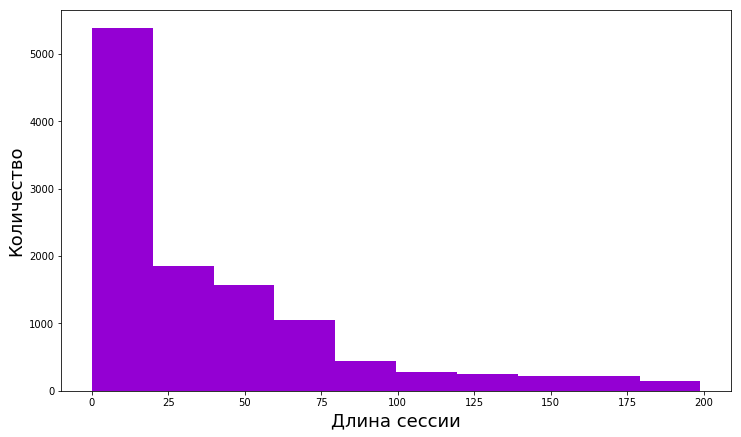

In [21]:
hist_data = train_data_10users[train_data_10users['session_timespan'] < 200]['session_timespan']
plt.figure(figsize=(12, 7))
plt.hist(hist_data, color='darkviolet')
plt.xlabel('Длина сессии', fontsize=18)
plt.ylabel('Количество', fontsize=18)

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

Text(0, 0.5, 'Количество')

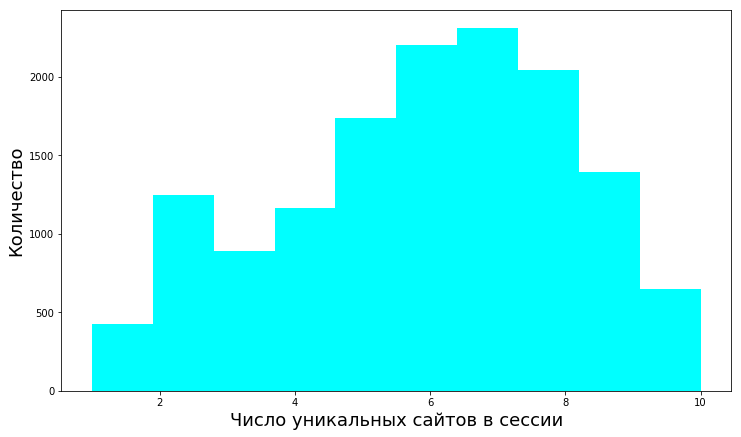

In [22]:
hist_data = train_data_10users['#unique_sites']
plt.figure(figsize=(12, 7))
plt.hist(hist_data, color='aqua')
plt.xlabel('Число уникальных сайтов в сессии', fontsize = 18)
plt.ylabel('Количество', fontsize = 18)

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

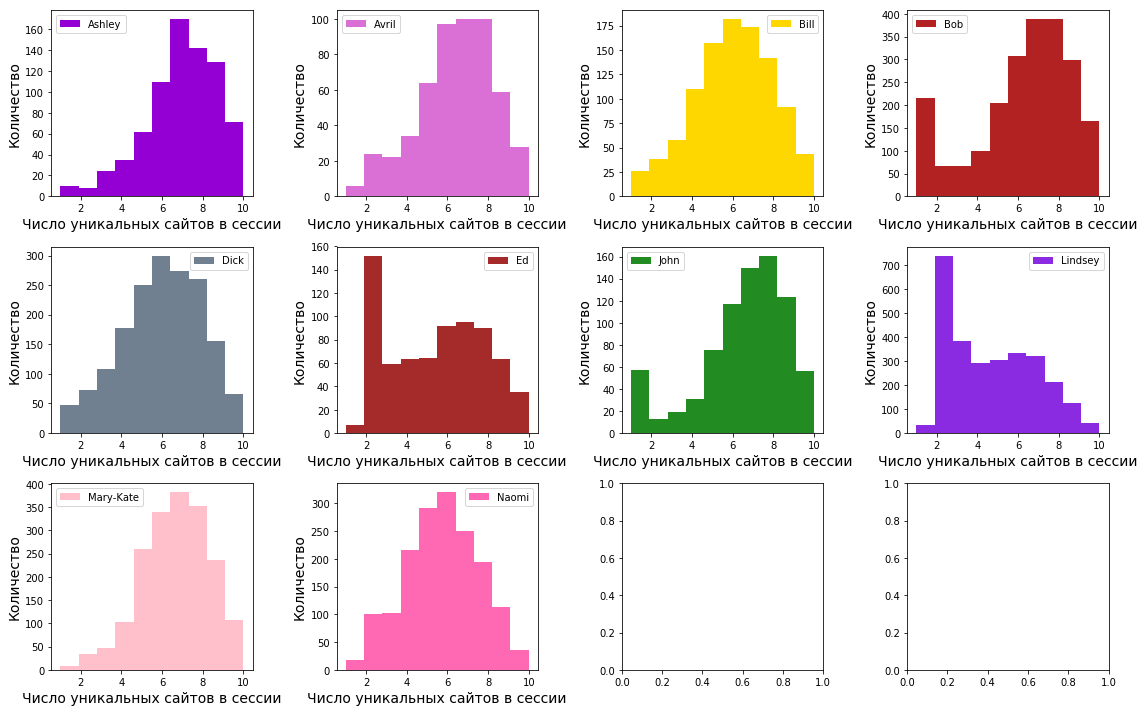

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in enumerate(train_data_10users.groupby('target')):
    i = idx // 4
    k = idx % 4
    hist_data = sub_df['#unique_sites']
    axes[i, k].hist(hist_data, label=user, color=color_dic[user])
    axes[i, k].legend()
    axes[i, k].set_xlabel('Число уникальных сайтов в сессии', fontsize=14)
    axes[i, k].set_ylabel('Количество', fontsize=14)
    plt.tight_layout()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

Text(0, 0.5, 'Количество')

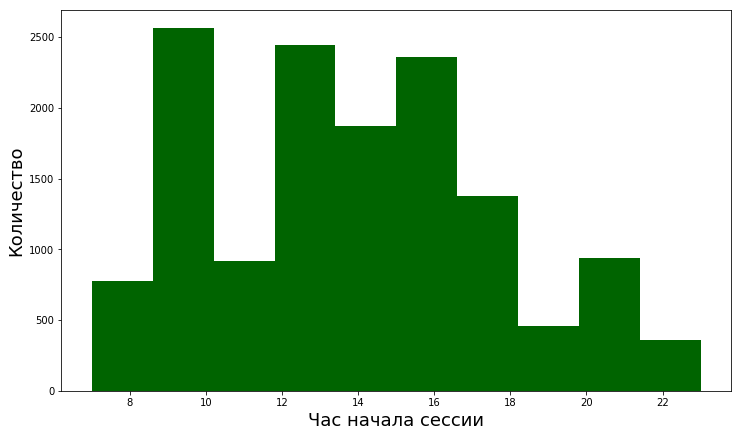

In [24]:
hist_data = train_data_10users['start_hour']

plt.figure(figsize=(12, 7))
plt.hist(hist_data, color='darkgreen')
plt.xlabel('Час начала сессии', fontsize=18)
plt.ylabel('Количество', fontsize=18)

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

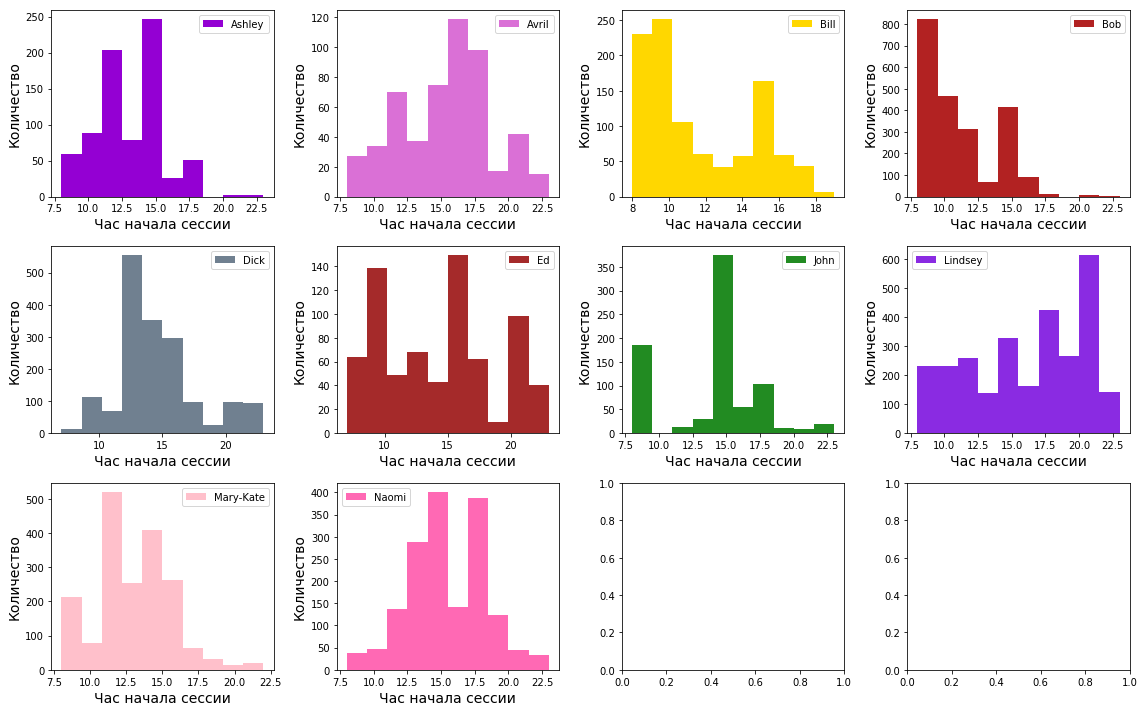

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in enumerate(train_data_10users.groupby('target')):
    i = idx // 4
    k = idx % 4
    hist_data = sub_df['start_hour']
    axes[i, k].hist(hist_data, label=user, color=color_dic[user])
    axes[i, k].legend()
    axes[i, k].set_xlabel('Час начала сессии', fontsize=14)
    axes[i, k].set_ylabel('Количество', fontsize=14)
    plt.tight_layout()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

Text(0, 0.5, 'Количество')

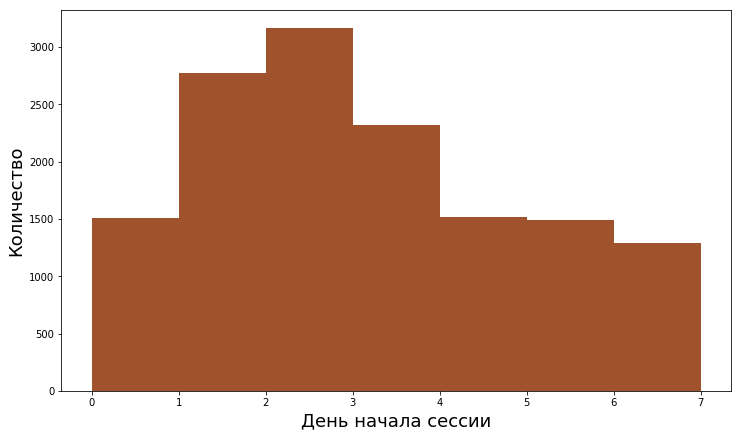

In [26]:
hist_data = train_data_10users['day_of_week']
plt.figure(figsize=(12, 7))
plt.hist(hist_data, color='sienna', bins=range(8))
plt.xlabel('День начала сессии', fontsize=18)
plt.ylabel('Количество', fontsize=18)

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

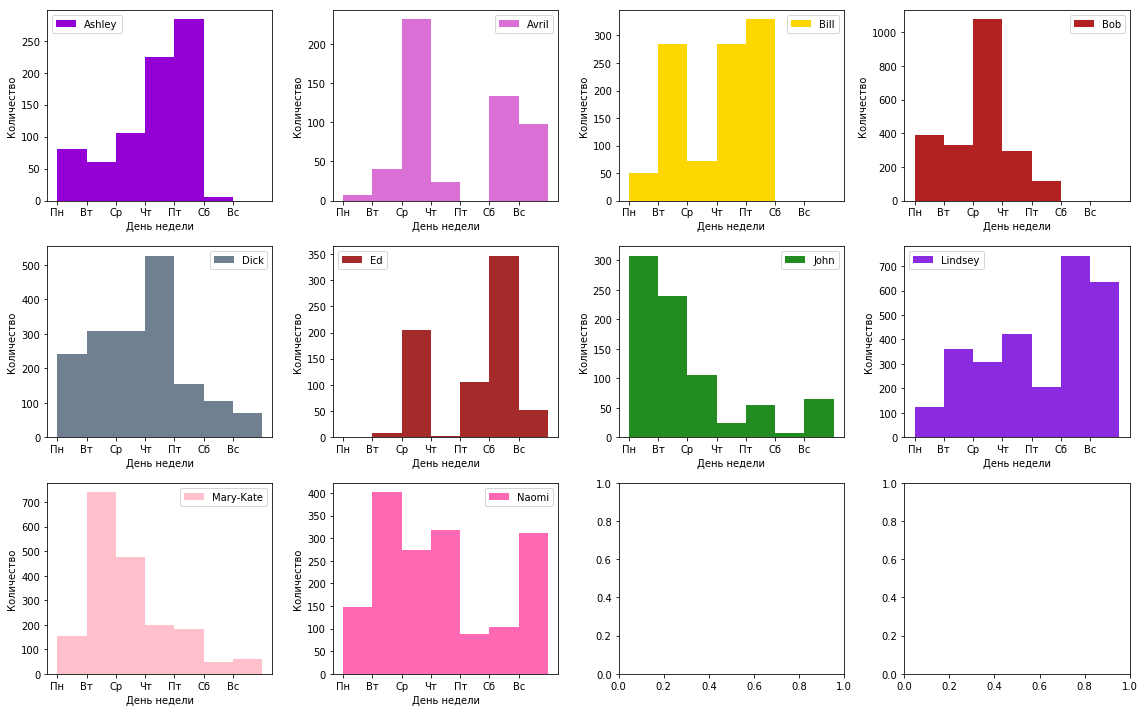

In [68]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in enumerate(train_data_10users.groupby('target')):
    i = idx // 4
    k = idx % 4
    day_of_week_hist = sub_df['day_of_week']
    axes[i, k].hist(day_of_week_hist, label=user, color=color_dic[user], bins=range(8))
    axes[i, k].legend()
    axes[i, k].set_xlabel('День недели')
    axes[i, k].set_ylabel('Количество')
    plt.tight_layout()
    axes[i, k].set_xticks(range(0, 7))
    axes[i, k].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

Ashley: в среднем 6-7 уникальных сайтов за сессию в течение рабочего дня. В основном будние дни с ростом к пятнице.

Avril: в среднем 7-8 уникальных сайтов за сессию. Пик после 15. В середине недели и в выходные.

Bill: в среднем 6-7 уникальных сайтов за сессию. Пик утром и в обед, В будние дни.

Bob:  в среднем 8-9 уникальных сайтов за сессию. Пик утром и в обед. В будние дни.

Dick: в среднем 6-7 уникальных сайтов за сессию. В обед и вечер. Чаще в будние дни.

Ed: равномерное распределение числа уникальных сайтов за сессию. Обычно утром, днем и вечером. Пик в среду и в субботу.

John: в среднем 8-9 уникальных сайтов за сессию. Обычно утром и в обед. Пик в начале рабочей недели.

Lindsey: равномерное распределение числа уникальных сайтов за сессию. Равномерно. Чаще в выходные.

Mary-Kate: в среднем 7-8 уникальных сайтов за сессию. В течении рабочего дня, пик в обед. Пик во Вт и в Ср.

Naomi: в среднем 6 уникальных сайтов за сессию. Обычно в обед и после 18. Пик в середине рабочей недели и в Вс.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [28]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as f:
    site_freq_10 = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [29]:
site_freq_10_sorted = sorted(site_freq_10.items(), key=lambda x: x[1][1], reverse=True)

top10_ids = [x[1][0] for x in site_freq_10_sorted[:10]]
top10_freqs = [x[1][1] for x in site_freq_10_sorted[:10]]
top10_sites = [x[0] for x in site_freq_10_sorted[:10]]

print('{:>5} {:>5}  {}'.format('ID', 'Freq', 'Site'))
for id_num, freq, site in zip(top10_ids, top10_freqs, top10_sites):
    print('{:5} {:5}  {}'.format(id_num, freq, site))

   ID  Freq  Site
  210  8300  s.youtube.com
   51  7813  www.google.fr
    4  5441  www.google.com
  183  4158  mail.google.com
   15  4141  www.facebook.com
   52  3758  apis.google.com
  700  3244  r3---sn-gxo5uxg-jqbe.googlevideo.com
  214  3094  r1---sn-gxo5uxg-jqbe.googlevideo.com
  187  2630  plus.google.com
  184  2089  accounts.google.com


**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

[Text(0, 0, 's.youtube.com'),
 Text(0, 0, 'www.google.fr'),
 Text(0, 0, 'www.google.com'),
 Text(0, 0, 'mail.google.com'),
 Text(0, 0, 'www.facebook.com'),
 Text(0, 0, 'apis.google.com'),
 Text(0, 0, 'r3---sn-gxo5uxg-jqbe.googlevideo.com'),
 Text(0, 0, 'r1---sn-gxo5uxg-jqbe.googlevideo.com'),
 Text(0, 0, 'plus.google.com'),
 Text(0, 0, 'accounts.google.com')]

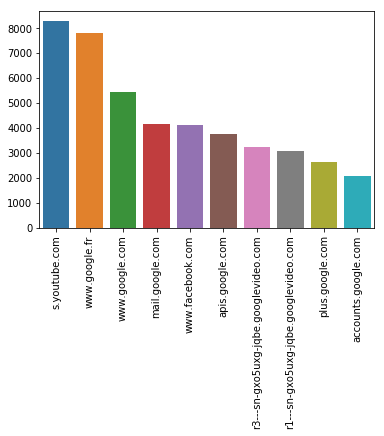

In [30]:
ax = sns.barplot(top10_sites, top10_freqs)
ax.set_xticklabels(top10_sites, rotation=90)

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [40]:
def hour_to_day_time(hour):
    if 0 < hour <= 6: 
        return 0
    elif 6 < hour <= 12: 
        return 1
    elif 12 < hour <= 18: 
        return 2
    else:
        return 3

In [36]:
def feature_engineering(path_to_csv_files, site_freq_path, features, session_length, window_size):
    df = prepare_train_set_with_fe(path_to_csv_files, site_freq_path, features,
                              session_length=session_length, window_size=window_size)
    df['day_period'] = df['start_hour'].apply(hour_to_day_time)
    return df

In [76]:
new_features_10users = feature_engineering(PATH_TO_DATA + '/10users',
                                           PATH_TO_DATA + '/site_freq_10users.pkl',
                                           features=feature_names, session_length=10, 
                                           window_size=10)
new_features_10users['target'] = new_features_10users['target'].map(id_name_dict)

In [77]:
new_features_10users.head()

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0     51     51    183      4    184    186     51    188     52     186   
1    189    183      4    188    183     52    189    183     51     183   
2    184    186      4     95      1     51     52    183      4     184   
3     52     51     51    184    183    183      4    183    185      52   
4    186    184    185    186    183      4    188    183    188     189   

   time_diff1  time_diff2  ...  time_diff5  time_diff6  time_diff7  \
0           1           5  ...          11           3           2   
1           0           4  ...           1           0           0   
2           0           0  ...           5           1           2   
3           0           1  ...           1           0           1   
4           3           0  ...           1           0           0   

   time_diff8  time_diff9  time_diff10  session_timespan  #unique_sites  \
0           0           2            2                24              7   
1           0           3            0                34              6   
2           0           0            0            107052              8   
3           1           0           14                 4              6   
4           3           1            0                 8              7   

   start_hour  day_of_week     target  day_period  
0          10            5  Mary-Kate           1  
1          10            5  Mary-Kate           1  
2          10            5  Mary-Kate           1  
3          16            6  Mary-Kate           2  
4          16            6  Mary-Kate           2  

[5 rows x 26 columns]

In [78]:
new_features_150users = feature_engineering(PATH_TO_DATA + '/150users',
                                           PATH_TO_DATA + '/site_freq_150users.pkl',
                                           features=feature_names, session_length=10, 
                                           window_size=10)
new_features_150users['target'] = new_features_150users['target'].map(id_name_dict)

In [79]:
new_features_150users.head()

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0      1      1     28      3     24     26      1     29      2      26   
1     30     28      3     29     28      2     30     28      1      28   
2     24     26      3      9     11      1      2     28      3      24   
3      2      1      1     24     28     28      3     28     25       2   
4     26     24     25     26     28      3     29     28     29      30   

   time_diff1  time_diff2  ...  time_diff5  time_diff6  time_diff7  \
0           1           5  ...          11           3           2   
1           0           4  ...           1           0           0   
2           0           0  ...           5           1           2   
3           0           1  ...           1           0           1   
4           3           0  ...           1           0           0   

   time_diff8  time_diff9  time_diff10  session_timespan  #unique_sites  \
0           0           2            2                24              7   
1           0           3            0                34              6   
2           0           0            0            107052              8   
3           1           0           14                 4              6   
4           3           1            0                 8              7   

   start_hour  day_of_week     target  day_period  
0          10            5  Mary-Kate           1  
1          10            5  Mary-Kate           1  
2          10            5  Mary-Kate           1  
3          16            6  Mary-Kate           2  
4          16            6  Mary-Kate           2  

[5 rows x 26 columns]

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

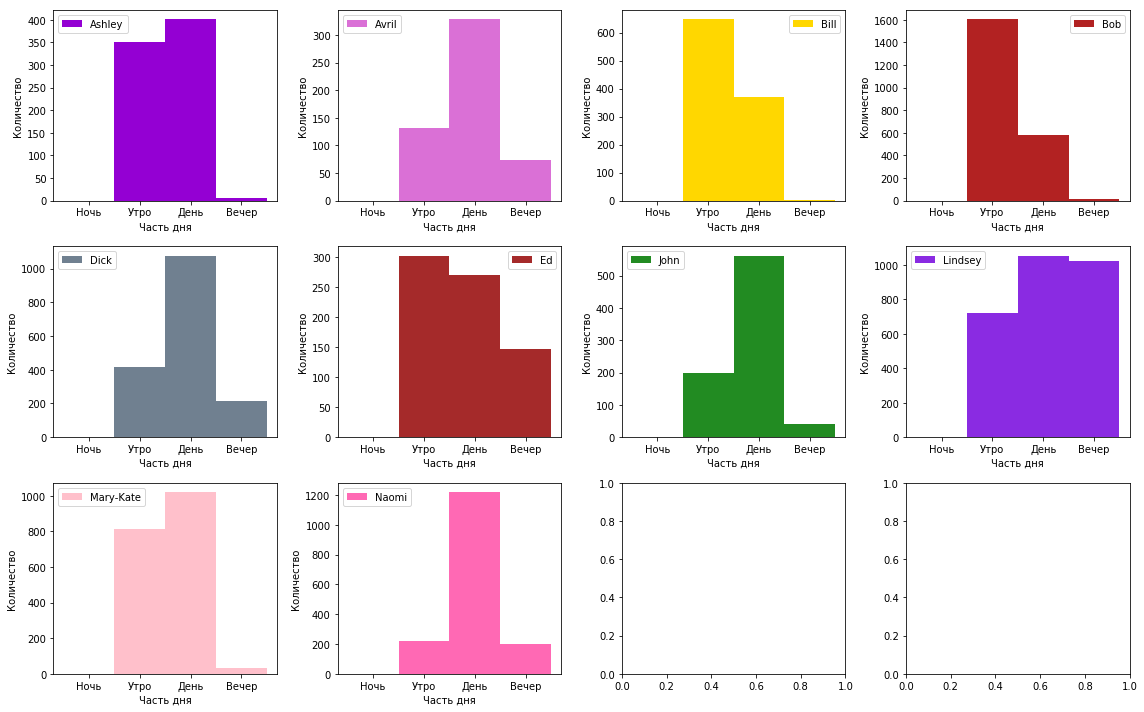

In [81]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in enumerate(new_features_10users.groupby('target')):
    i = idx // 4
    k = idx % 4
    hist_data = sub_df['day_period']
    axes[i, k].hist(hist_data, bins=range(5), color=color_dic[user], label=user)
    axes[i, k].legend()
    axes[i, k].set_xlabel('Часть дня')
    axes[i, k].set_ylabel('Количество')
    plt.tight_layout()
    axes[i, k].set_xticks([0.5, 1.5, 2.5, 3.5])
    axes[i, k].set_xticklabels(['Ночь', 'Утро', 'День', 'Вечер'])

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [83]:
selected_features_10users = new_features_10users
selected_features_150users = new_features_150users 

In [84]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 